# Convergence and performance

To optimize simulation time vs accuracy, an estimate of the acaling of the algorithm is required. For this purpose, there are two methods provided in the `Cell` and the `Layer` classes.

Below a simple example is set up to quickly run these tests. The structure here is a 300 nm layer of silicon on glass with cylindrical air holes arranged in a square lattice of periodicity 1 μm.

In [ ]:
import sys
sys.path.append('../../') # Modify this line

import beams as bm
import numpy as np
from time import time
import matplotlib.pyplot as plt

p = bm.Vector2d(1, 1)

air = bm.Material()
si = bm.Material(index=3.4) 
sio2 = bm.Material(epsilon=1.5 ** 2)

hole = bm.Ellipse(r=.3, material=air) 
phc = bm.Layer(h=.3, material=si, shapes=[hole], resolution=500)

## Linear algebra

The size of the linear algebra problems is determined by the number of modes $N$. The accuracy and performance of `Layer.compute_eigs` and `Cell.linsolve` methods can be obtained using `Cell.convergence`.

#### Parameters
- `N_max`: The maximum number of modes to compute upto. The method will run the simulation for every odd integer from 1 to `N_max`.
- `**kwargs`: The frequency and angles that are passed to the `Cell.R_T()` method.

In [116]:
inc = bm.Layer()
sub = bm.Layer(material=sio2)
cell = bm.Cell(period=p, N=5, layers=[inc, phc, sub])

f = 0.75
a = bm.Vector3d(np.pi / 3, np.pi / 6, np.pi / 2)

N_max = 35
(RT, tt) = cell.convergence(N_max, freq=f, angles=a)

EPS: (1, 1)
N = (1, 1): R = 0.20595, T = 0.82672
1.715s taken per iteration.
EPS: (9, 9)
N = (3, 3): R = 0.72762, T = 0.27238
1.075s taken per iteration.
EPS: (25, 25)
N = (5, 5): R = 0.74656, T = 0.25344
0.096s taken per iteration.
EPS: (49, 49)
N = (7, 7): R = 0.63095, T = 0.36905
0.181s taken per iteration.
EPS: (81, 81)
N = (9, 9): R = 0.61906, T = 0.38094
0.359s taken per iteration.
EPS: (121, 121)
N = (11, 11): R = 0.61294, T = 0.38706
0.62s taken per iteration.
EPS: (169, 169)
N = (13, 13): R = 0.61003, T = 0.38997
1.237s taken per iteration.
EPS: (225, 225)


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=[12.8, 4.8])
ni = np.arange(1, N_max + 1, 2) ** 2

ax[0].loglog(ni[1:], np.abs(np.diff(RT[0])), linewidth=2)
ax[0].set_xlabel('Number of modes')
ax[0].set_ylabel('Error')

ax[1].loglog(ni, tt, linewidth=2)
ax[1].set_xlabel('Number of modes')
ax[1].set_ylabel('Time (s)')
plt.show()

## FFT

The scaling of the FFT can be obtained through the `Layer.fft_convergence` method which returns a tuple of the time taken for each computation and the maximum difference in the norms of the FFT matrices compared to the previous computation.

#### Parameters
- `max_res`: The maximum resolution to compute the FFT for.
- `n_res`: The number of steps in the resolution from the minimum i.e. $2N-1$ to `max_res`.
- `N`: Defines the minimum resolution and truncates the central $2N-1$ orders from the FFT solution.
- `period`: The period of the lattice. Increasing the period will also increase size of grid if resolution is constant.
- `n_iter=3`: The number of computations over which the time is averaged.

In [ ]:
m_res = 1e4
n = 25
N = 11
(err, T) = phc.fft_convergence(m_res, n, N, p)

Since the values are stored, the scaling and accuracy can be quickly visualized.

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=[12.8, 4.8])
ri = np.linspace(2 * N - 1, m_res, n)

ax[0].loglog(ri, err, linewidth=2)
ax[0].set_xlabel('Resolution (px/μm)')
ax[0].set_ylabel('Error')

ax[1].loglog(ri, T, linewidth=2)
ax[1].set_xlabel('Resolution (px/μm)')
ax[1].set_ylabel('Time (s)')
plt.show()

## Parallelism Trials

In [1]:
from numba import njit, jit
from numba import prange
import numba
import time
import sys
sys.path.append('../../') # Modify this line

import beams as bm
import numpy as np
import matplotlib.pyplot as plt

# from cython.parallel import prange
import numexpr as ne
import os

In [85]:
a = np.random.random((1000, 10, 10))
b = np.copy(a)
c = np.copy(a)
d = np.copy(a)

### Using Concurrent Futures

In [36]:
def future_done(r, i, a):
    a[i] = r.result()

In [92]:
from concurrent import futures
import functools

before = time.time()
with futures.ThreadPoolExecutor(max_workers=2) as executor:
    for i in prange(a.shape[0]):
        future_result = executor.submit(lapack_inverse, a[i])
        future_result.add_done_callback(functools.partial(future_done, i=i, a=a))
after = time.time()
print(after - before)

0.09736299514770508


### Using Cython, OpenMP and prange

In [88]:
from cython.parallel import prange
import cython

before = time.time()
for i in prange(a.shape[0], nogil=True, schedule='static'):
    a[i] = lapack_inverse(a[i])
after = time.time()
print(after - before)

0.03628110885620117


### Using LAPACK

In [2]:
from scipy.linalg import lapack
import timeit

In [18]:
def lapack_inverse(a):
    b = np.eye(a.shape[0], dtype=a.dtype)
    _, _, a, _ = lapack.dgesv(a, b)

In [94]:
lapack_inverse_time = []
np_inverse_time = []
cython_inverse_time = []
dims = [10, 50, 100, 250, 500]

for dim in dims:
    random_mat = np.random.random((1000, dim, dim))
    
    lapack_mat = np.copy(random_mat)
    before = time.time()
    for i in range(lapack_mat.shape[0]):
        lapack_inverse(lapack_mat[i])
    after = time.time()
    print(after - before)
    lapack_inverse_time.append(after - before)
    
    np_mat = np.copy(random_mat)
    before = time.time()
    for i in range(np_mat.shape[0]):
        np.linalg.inv(np_mat[i])
    after = time.time()
    print(after - before)
    np_inverse_time.append(after - before)
    
    cython_mat = np.copy(random_mat)
    before = time.time()
    for i in prange(cython_mat.shape[0], nogil=True, schedule='dynamic'):
        lapack_inverse(cython_mat[i])
    after = time.time()
    print(after - before)
    cython_inverse_time.append(after - before)

0.0330202579498291
0.042738914489746094
0.0388181209564209
0.2257678508758545
0.25302600860595703
0.39342522621154785
0.5749969482421875
0.49893879890441895
0.4580662250518799
3.384368896484375
2.7387912273406982
2.833681106567383


KeyboardInterrupt: 

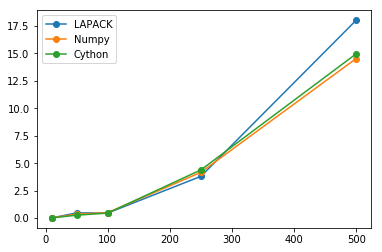

In [93]:
plt.plot(dims, lapack_inverse_time, 'o-')
plt.plot(dims, np_inverse_time, 'o-')
plt.plot(dims, cython_inverse_time, 'o-')
plt.legend(['LAPACK', 'Numpy', 'Cython'])
plt.show()

In [73]:
lapack_inverse_time = []
np_inverse_time = []
dims = [100, 250, 500, 750, 1000]

for dim in dims:
    random_mat = np.random.random((dim, 100, 100))
    
    before = time.time()
    lapack_mat = np.copy(random_mat)
    for i in range(lapack_mat.shape[0]):
        lapack_inverse(lapack_mat[i])
    after = time.time()
    print(after - before)
    lapack_inverse_time.append(after - before)
    
    before = time.time()
    np_mat = np.copy(random_mat)
    for i in range(np_mat.shape[0]):
        np.linalg.inv(np_mat[i])
    after = time.time()
    print(after - before)
    np_inverse_time.append(after - before)

0.051332950592041016
0.11538887023925781
0.13680624961853027
0.12067198753356934
0.22940421104431152
0.25310492515563965
0.31233882904052734
0.3215639591217041
0.4002110958099365
0.44547319412231445


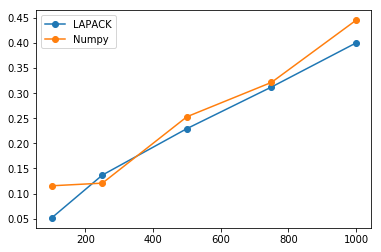

In [74]:
plt.plot(dims, lapack_inverse_time, 'o-')
plt.plot(dims, np_inverse_time, 'o-')
plt.legend(['LAPACK', 'Numpy'])
plt.show()